VCP

In [1]:
# Вроде есть проблема с количеством рекурсий, на виндовс ее можно решить только так
import sys
sys.setrecursionlimit(10**6)
# https://mat.tepper.cmu.edu/COLOR/instances.html

In [2]:
import networkx as nx # крутая штука для операций с графами
import cplex
import time
import matplotlib.pyplot as plt
from threading import Timer # для остановки алгоритма по достижении лимита по времени

In [3]:
# читаем граф
def get_graph(graph_name):
    edges = []
    vertices_num = 0
    with open('vcp graphs/' + graph_name, 'r') as file:
        for line in file:
            line = line.split()
            if line[0] == 'e':
                edges.append((int(line[1]), int(line[2])))
                if int(line[1]) > vertices_num:
                    vertices_num = int(line[1])
                if int(line[2]) > vertices_num:
                    vertices_num = int(line[2])                
    return vertices_num, edges

In [59]:
class MyClass:
    def __init__(self, vertices_num, edges, stop_time=30, test=False):
        Timer(stop_time, self.exitfunc).start() # early stopping
        self.check_time = True # early stopping
        self.vertices_num = vertices_num # количество вершин
        self.edges = edges # все ребра
        self.nx_graph = nx.Graph(edges) # nx граф
        '''
        У нас может быть проблема с тем, что в графе есть вершины у которых нет ни одного ребра и тогда networkx
        не заносит их в граф, а для больших графов (которые и так не считаются) это может быть проблемой и симплекс
        выдает ошибку, не до конца понял почему, но вот такое решение работает
        '''
        for node in range(1, self.vertices_num + 1):
            if node not in self.nx_graph.nodes:
                self.nx_graph.add_node(node)

        
        self.colors = self.get_init_colors() # храним все цвета
        self.color_ind = len(self.colors) - 1 # индекс текущего цвета для добавления в master model
        # create master model
        self.create_master_model(len(self.colors))
        self.update_model(update_type='master init', constraints=self.colors)
        # create valuable constraints
        self.create_valuable_constraints_for_slave_problem()
        # create slave model
        self.create_slave_model()
        self.update_model(update_type='slave init', constraints=None)
        # всякие доп штуки
        self.branching = True 
        self.branch_num = 1
        self.restricted_colors = []
#         self.min_colors = 1000 # Для проверки можно раскоментить эту строку и посмотреть что модель находит решение
        self.current_depth = 0
        # для тестирования
        if test:
            self.min_colors = 10000
        else:
            nx.draw(self.nx_graph, with_labels=True) # нарисуем граф, все равно они не большие
            plt.show()
        print('First Solution', self.min_colors) # наше первое решение
        
    
    # выход по таймеру
    def exitfunc(self):
        self.check_time = False
    
    # обертка для return что нам надо для вывода статистики
    def return_some(self):
        self.BnP()
        return self.master_model, self.slave_model, self.min_colors, self.colors
    
    # первоначальные раскраски для master model
    def get_init_colors(self):
        # в целом просто как и в BnB получаем много раскрасок и задаем их как начальное ограничение
        constraints = []
        strategies = [nx.coloring.strategy_largest_first,
                      nx.coloring.strategy_independent_set,
                      nx.coloring.strategy_connected_sequential_bfs,
                      nx.coloring.strategy_connected_sequential_dfs,
                      nx.coloring.strategy_saturation_largest_first]
        self.min_colors = self.vertices_num
        for strategy in strategies:
            d = nx.coloring.greedy_color(self.nx_graph, strategy=strategy)
            colors = set(d.values())
            
            # здесь получаем начальное решение, можно поставить его в __init__ равным 10000 и посмотреть правильно ли работает модель
            if len(colors) < self.min_colors:
                self.min_colors = len(colors)

            for color in colors:
                new_constraint = [key for key, value in d.items() if value == color]
                new_constraint = sorted(self.extend_colors(new_constraint))
                if new_constraint not in constraints:
                    constraints.append(new_constraint)
                    
        strategies = [nx.coloring.strategy_random_sequential] * self.vertices_num
        for strategy in strategies:
            d = nx.coloring.greedy_color(self.nx_graph, strategy=strategy)
            colors = set(d.values())
            
            # set colors_num
            if len(colors) < self.min_colors:
                self.min_colors = len(colors)

            for color in colors:
                new_constraint = [key for key, value in d.items() if value == color]
                new_constraint = sorted(self.extend_colors(new_constraint))
                if new_constraint not in constraints:
                    constraints.append(new_constraint)   
                    
        return constraints
    
    # пытаемся расширить раскраску до максимальной
    # какого-то критерия останова не делал, т.к. по сравнению со временем решения всей задачи оно незначительно
    def extend_colors(self, constraints):
        save_extended_constraint = []
        max_len = len(constraints)
        for i in range(self.vertices_num):
            temp_constraints = nx.maximal_independent_set(self.nx_graph, constraints)
            if len(temp_constraints) >= max_len:
                bad_iters = 0
                max_len = len(temp_constraints)
                save_extended_constraint = temp_constraints
                    
        return save_extended_constraint
    
    # создаем master model
    def create_master_model(self, obj_len):
        self.master_model = cplex.Cplex()
        self.master_model.set_results_stream(None)        
        self.master_model.objective.set_sense(self.master_model.objective.sense.minimize)
        self.master_model.variables.add([1] * obj_len)
    
    # создаем slave model, затем будем ее обновлять
    def create_slave_model(self):
        weights = [1 for i in range(self.vertices_num)] # это просто количество первоначальных ограничений
        self.slave_model = cplex.Cplex()
        self.slave_model.set_results_stream(None)
        self.slave_model.objective.set_sense(self.slave_model.objective.sense.maximize)
        self.slave_model.variables.add(weights, types=[self.slave_model.variables.type.binary] * len(weights))
       
    # создаем большие (по возможности) ограничения для slave model
    def create_valuable_constraints_for_slave_problem(self):
        self.valuable_constraints = []
        # создаем дополненный граф
        complement_graph = nx.complement(self.nx_graph)
        # просто пытаемся циклом по всем вершинам netwrokx их расширить один раз
        for i in range(1, self.vertices_num + 1):
            max_ind_set = nx.maximal_independent_set(complement_graph, [i])
            max_ind_set = sorted(max_ind_set)
            if max_ind_set not in self.valuable_constraints:
                self.valuable_constraints.append(max_ind_set)
            
        # расширяем по раскраскам
        strategies = [nx.coloring.strategy_largest_first,
                      nx.coloring.strategy_independent_set,
                      nx.coloring.strategy_connected_sequential_bfs,
                      nx.coloring.strategy_connected_sequential_dfs,
                      nx.coloring.strategy_saturation_largest_first]
        strategies += [nx.coloring.strategy_random_sequential] * self.vertices_num

        for strategy in strategies:
            d = nx.coloring.greedy_color(complement_graph, strategy=strategy)
            for color in set(d.values()):
                temp = [key for key, value in d.items() if value == color]
                if len(temp) != 1 and sorted(temp) not in self.valuable_constraints:
                    self.valuable_constraints.append(sorted(temp))
    
    # функция для создания первоначальных ограничений и добавления новых
    def update_model(self, update_type, constraints=None):
        # создаем первоначальную модель с нашими раскрасками
        if update_type == 'master init':
            for node in range(1, self.vertices_num + 1):
                node_colors = [num for num, constraint in enumerate(constraints) if node in constraint]
                temp_constraints = [cplex.SparsePair(ind=node_colors, val=[1] * len(node_colors))]
                self.master_model.linear_constraints.add(lin_expr=temp_constraints, senses=['G'], rhs=[1])
        # создаем slave model со всеми ребрами и valuable constraints
        elif update_type == 'slave init':
            # 2-size constraints
            for edge in self.edges:
                temp_constraints = [cplex.SparsePair(ind=[i-1 for i in edge], val=[1] * len(edge))]
                self.slave_model.linear_constraints.add(lin_expr=temp_constraints, senses=['L'], rhs=[1])
            # valuable (mb) constraints
            for edge in self.valuable_constraints:
                temp_constraints = [cplex.SparsePair(ind=[i-1 for i in edge], val=[1] * len(edge))]
                self.slave_model.linear_constraints.add(lin_expr=temp_constraints, senses=['L'], rhs=[1])
        # обновляем objective в slave model, это прям сильное ускорение по сравнению с тем, чтобы создавать новую
        elif update_type == 'slave variables':
            for num, weight in enumerate(constraints):
                self.slave_model.objective.set_linear(num, weight) 
                
    '''
    Здесь мы ищем все stable sets. Я использовал только cplex (slave model), т.к. он работает ну очень быстро и смысла в
    эвристике нет. В целом эвристику можно было бы добавить, но если делать ее быстрой/слабой то смысла в ней особо нет,
    а если делать сильной/долгой, то мы скорее всего будем дольше симплекса работать. В итоге вполне неплохо использовать
    просто симплекс, т.к. основная проблем не во времени работы, а в количестве ветвлений, которое намного больше, чем
    было в BnB, что пичально, но может я кстати просто криво написал и у меня все не так работает.
    Так как это в целом основная штука в задаче, ниже попытаюсь поподробней описать что и как там происходит
    '''
    def find_stable_sets(self):
        # В перый раз получаем решение двойственной задачи и обновляем slave model
        self.master_model.solve()
        weights = self.master_model.solution.get_dual_values(0, self.vertices_num-1)
        weights = [0.0  if i - 1e-6 <= 0.0 else 1.0 if i + 1e-6 >= 1.0 else i for i in weights]
        weights = [1e-6 if i == 0 else i for i in weights]
        self.update_model(update_type='slave variables', constraints=weights)
        
        # ищем с помощью симплекса нарушенные ограничения, почему нет эвристики писал выше
        while True:
            # получаем решение slave model
            self.slave_model.solve()
            slave_model_solution = self.slave_model.solution.get_values()
            slave_model_solution = [0.0  if i - 1e-6 <= 0.0 else 1.0 if i + 1e-6 >= 1.0 else i for i in slave_model_solution]
            sum_weights = self.slave_model.solution.get_objective_value()
            # смотрим на решение и если больше 1, то возможно добавляем его к master model
            if sum_weights > 1:
                new_constraints = [i for i in range(len(slave_model_solution)) if slave_model_solution[i] == 1]
                # здесь надо посмотреть не нашли ли мы что-то кривое из-за того, что 0 приравнивали к 1e-6
                check_for_zeros = [weights[i] for i in new_constraints if weights[i] != 1e-6]
                if len(check_for_zeros) <= 1 or sum(check_for_zeros) <= 1 + 1e-6:
                    break
                # расширяем (вширь) master model
                self.colors.append(sorted([i + 1 for i in new_constraints]))
                self.color_ind += 1
                self.master_model.variables.add([1])
                for new_constraint in new_constraints:
                    self.master_model.linear_constraints.set_linear_components(new_constraint, [[self.color_ind], [1]])
                
                # опять получаем решение и обновляем slave model
                self.master_model.solve()
                weights = self.master_model.solution.get_dual_values(0, self.vertices_num-1)
                weights = [0.0  if i - 1e-6 <= 0.0 else 1.0 if i + 1e-6 >= 1.0 else i for i in weights]
                weights = [1e-6 if i == 0 else i for i in weights]
                self.update_model(update_type='slave variables', constraints=weights)
            else:
                break
    
    # функция из прошлых лаб, опять будем ветвиться по вершине с максимальным весом
    def get_bb_variable(self, solution):
        for i in range(len(solution)):
            if solution[i] not in [1.0, 0.0]:
                return i
        return None
#         bbvar = [(j, i) for j, i in enumerate(solution) if i != 0.0 and not i.is_integer()]
#         bbvar = max(bbvar, key = lambda x: x[1], default=(None, None))[0]
#         return bbvar
    
    # опять из прошлых лаб, добавляем ограничение на цвет
    def branch_master_model(self, bbvar, constraint_value, current_branch):
        bb_constraint = [[[bbvar], [1.0]]]
        bb_senses = ['E']
        bb_rhs = [constraint_value]
        bb_names = ['branch_{0}'.format(current_branch)]
        self.master_model.linear_constraints.add(lin_expr=bb_constraint, senses=bb_senses,
                                                 rhs=bb_rhs, names=bb_names)
        
    # основная функция по которой и идем рекурсией
    def BnP(self):
        if self.check_time == True: # выход по времени
            if self.branch_num % 2000 == 0: # давайте выводить каждый 2000 ветвлений
                print('BRANCH NUM:', self.branch_num, 'CURRENT DEPTH:', self.current_depth)
            self.find_stable_sets()
            # get bbvar
            master_solution = self.master_model.solution.get_values()
            master_solution = [0.0  if i - 1e-6 <= 0.0 else 1.0 if i + 1e-6 >= 1.0 else i for i in master_solution]
            bbvar = self.get_bb_variable(master_solution)
#             print(self.master_model.solution.get_objective_value())
            
            if bbvar != None and self.master_model.solution.get_objective_value() < self.min_colors - 1 + 1e-6:
                
                # Изначально ветвимся по единице, тут все как и в прошлых лабах
                self.branch_num += 1 # увеличиваем ветвление на 1
                current_branch = self.branch_num
                self.branch_master_model(bbvar, 1, current_branch)
                self.current_depth += 1
                self.BnP()
                self.master_model.linear_constraints.delete('branch_{0}'.format(current_branch))
                
                
                '''
                Ветвление по нулю немного не так работает как раньше. Здесь фактически мы создаем новый запрешенный цвет,
                затем добавляем его в slave model, в целом больше разницы нет
                '''
                self.branch_num += 1 # увеличиваем ветвление на 1
                current_branch = self.branch_num
                self.branch_master_model(bbvar, 0, current_branch)
                self.restricted_colors.append(sorted(self.colors[bbvar]))
                new_constraint = [i-1 for i in self.colors[bbvar]]
                temp_constraints = [cplex.SparsePair(ind=new_constraint, val=[1] * len(new_constraint))]
                self.slave_model.linear_constraints.add(lin_expr=temp_constraints, senses='L',
                                                        rhs=[len(new_constraint)-1]) 
                self.BnP()
                self.master_model.linear_constraints.delete('branch_{0}'.format(current_branch))
                self.current_depth -= 1
                
                
            
                
                
            # если есть целочисленное решение (и нет нарушунных ограничений), то смотрим нашли ли мы что-то новое
            # опять же можете попробовать начальное решение задать 100000 и посмотреть что алгоритм корректно работает, наверное
            elif bbvar == None:
                new_solution = sum(master_solution)
                if new_solution < self.min_colors:
                    self.min_colors = new_solution
                    print('NUM OF COLORS:', sum(master_solution))

## Production (типо)

### Myciel

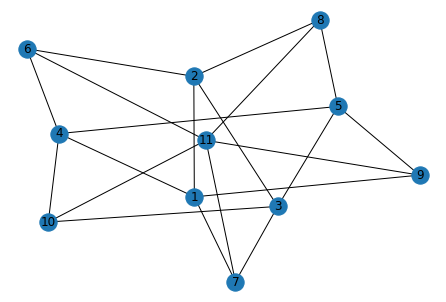

First Solution 4
Wall time: 1.65 s


In [5]:
%%time
# decision = 4
vertices_num, edges = get_graph('myciel3.col')
res = MyClass(vertices_num, edges, stop_time=60*60*2).return_some()

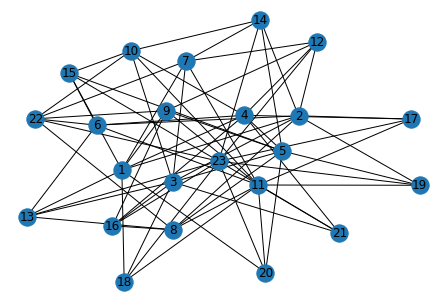

First Solution 5
BRANCH NUM: 2000 CURRENT DEPTH: 134
BRANCH NUM: 4000 CURRENT DEPTH: 47
BRANCH NUM: 6000 CURRENT DEPTH: 39
BRANCH NUM: 8000 CURRENT DEPTH: 53
BRANCH NUM: 10000 CURRENT DEPTH: 115
BRANCH NUM: 12000 CURRENT DEPTH: 270
Wall time: 14min 12s


In [6]:
%%time
# decision = 5
vertices_num, edges = get_graph('myciel4.col')
res = MyClass(vertices_num, edges, stop_time=60*60*2).return_some()

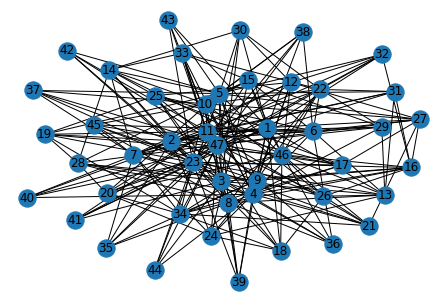

First Solution 6
BRANCH NUM: 2000 CURRENT DEPTH: 1001
BRANCH NUM: 4000 CURRENT DEPTH: 2001
Wall time: 3h 5s


In [7]:
%%time
# decision = 6
vertices_num, edges = get_graph('myciel5.col')
res = MyClass(vertices_num, edges, stop_time=60*60*3).return_some()

### Queen

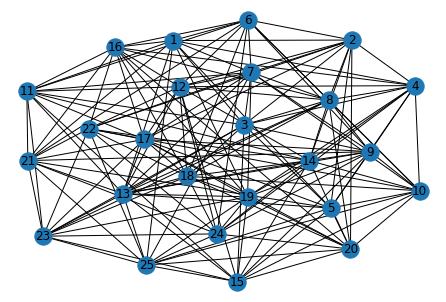

First Solution 5
Wall time: 864 ms


In [8]:
%%time
# decision = 5
vertices_num, edges = get_graph('queen5_5.col')
res = MyClass(vertices_num, edges, stop_time=60*60*2).return_some()

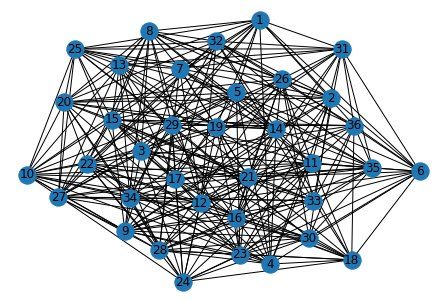

First Solution 8
NUM OF COLORS: 7.0
Wall time: 3.32 s


In [9]:
%%time
# decision = 7
vertices_num, edges = get_graph('queen6_6.col')
res = MyClass(vertices_num, edges, stop_time=60*60*2).return_some()

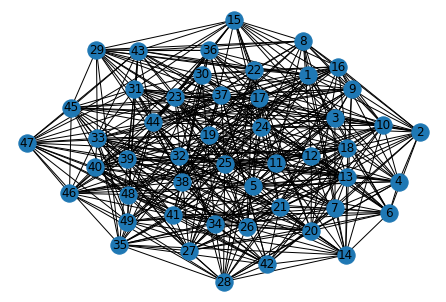

First Solution 9
NUM OF COLORS: 7.0
Wall time: 5.64 s


In [10]:
%%time
# decision = 7
vertices_num, edges = get_graph('queen7_7.col')
res = MyClass(vertices_num, edges, stop_time=60*60*2).return_some()

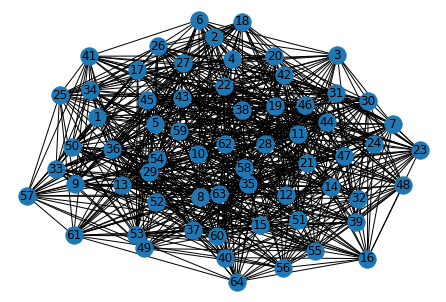

First Solution 11
NUM OF COLORS: 10.0
NUM OF COLORS: 9.0
Wall time: 15.6 s


In [11]:
%%time
# decision = 9
vertices_num, edges = get_graph('queen8_8.col')
res = MyClass(vertices_num, edges, stop_time=60*60*2).return_some()

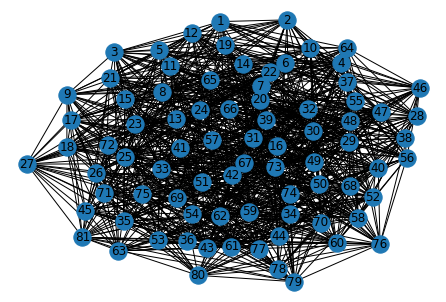

First Solution 12
NUM OF COLORS: 11.0
NUM OF COLORS: 10.0
Wall time: 5min 1s


In [12]:
%%time
# decision = 10
vertices_num, edges = get_graph('queen9_9.col')
res = MyClass(vertices_num, edges, stop_time=60*60*2).return_some()

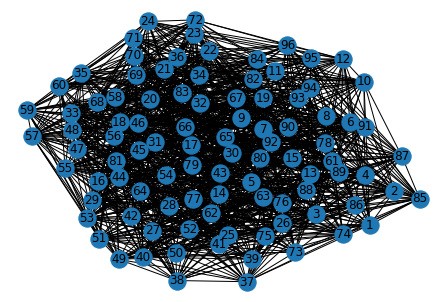

First Solution 14
NUM OF COLORS: 13.0
NUM OF COLORS: 12.0
Wall time: 1min 20s


In [13]:
%%time
# decision = 12
vertices_num, edges = get_graph('queen8_12.col')
res = MyClass(vertices_num, edges, stop_time=60*60*2).return_some()

### Games

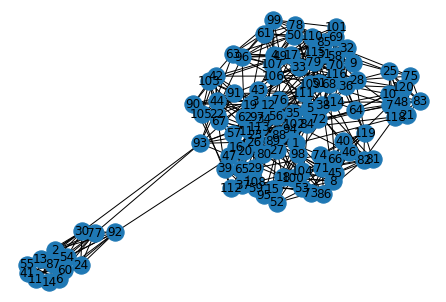

First Solution 9
Wall time: 6.87 s


In [7]:
%%time
# decision = 9
vertices_num, edges = get_graph('games120.col')
res = MyClass(vertices_num, edges, stop_time=60*60*2).return_some()

### Miles

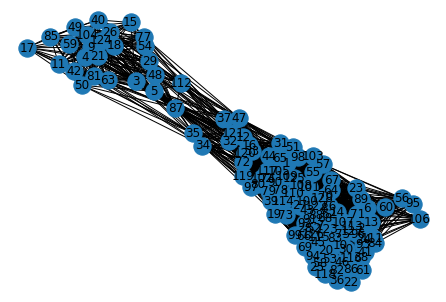

First Solution 42
Wall time: 24.5 s


In [8]:
%%time
# decision = 42
vertices_num, edges = get_graph('miles1000.col')
res = MyClass(vertices_num, edges, stop_time=60*60*2).return_some()

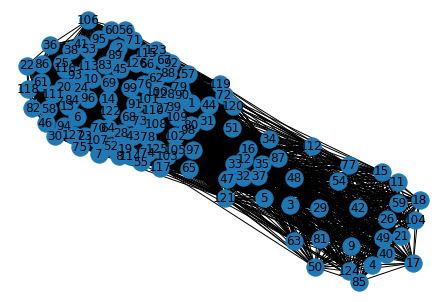

First Solution 73
Wall time: 31.3 s


In [9]:
%%time
# decision = 73
vertices_num, edges = get_graph('miles1500.col')
res = MyClass(vertices_num, edges, stop_time=60*60*2).return_some()

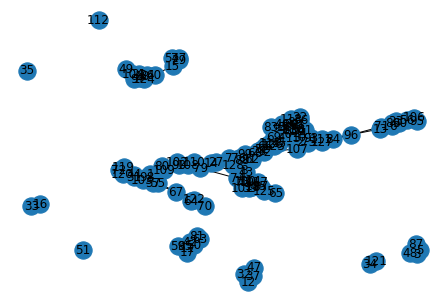

First Solution 8
Wall time: 16.3 s


In [10]:
%%time
# decision = 8
vertices_num, edges = get_graph('miles250.col')
res = MyClass(vertices_num, edges, stop_time=60*60*2).return_some()

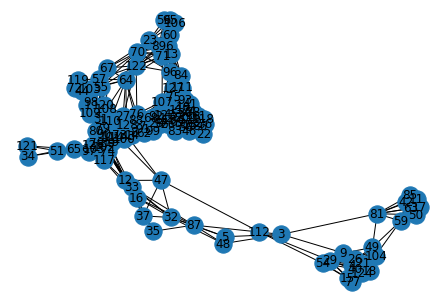

First Solution 20
Wall time: 20.3 s


In [11]:
%%time
# decision = 20
vertices_num, edges = get_graph('miles500.col')
res = MyClass(vertices_num, edges, stop_time=60*60*2).return_some()

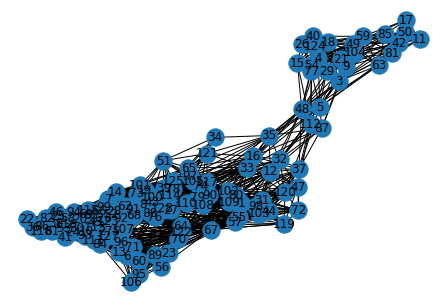

First Solution 31
Wall time: 22.7 s


In [12]:
%%time
# decision = 31
vertices_num, edges = get_graph('miles750.col')
res = MyClass(vertices_num, edges, stop_time=60*60*2).return_some()

### Names

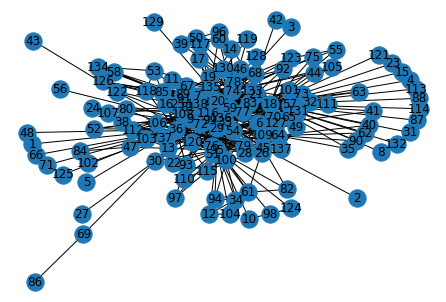

First Solution 11
Wall time: 43.7 s


In [13]:
%%time
# decision = 11
vertices_num, edges = get_graph('anna.col')
res = MyClass(vertices_num, edges, stop_time=60*60*2).return_some()

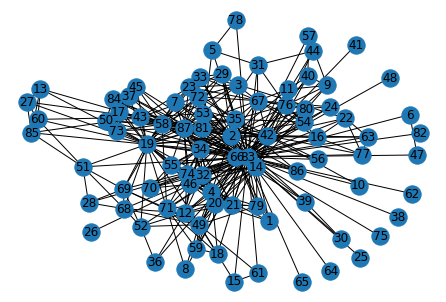

First Solution 11
Wall time: 8.99 s


In [14]:
%%time
# decision = 11
vertices_num, edges = get_graph('david.col')
res = MyClass(vertices_num, edges, stop_time=60*60*2).return_some()

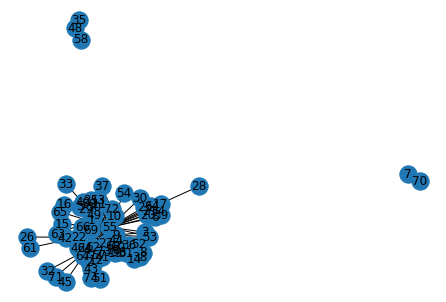

First Solution 11
Wall time: 4.01 s


In [54]:
%%time
# decision = 11
vertices_num, edges = get_graph('huck.col')
res = MyClass(vertices_num, edges, stop_time=60*60*2).return_some()

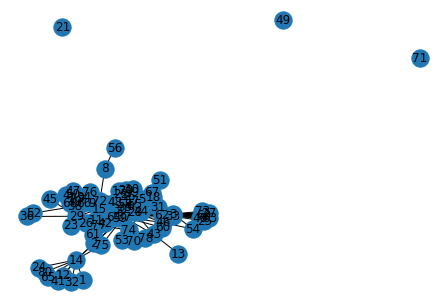

First Solution 10
Wall time: 6.43 s


In [55]:
%%time
# decision = 10
vertices_num, edges = get_graph('jean.col')
res = MyClass(vertices_num, edges, stop_time=60*60*2).return_some()